Some source of the Github datasets are brought into consideration:
https://github.com/epicprojects/blockchain-anomaly-detection

Perform

Original Dataset URL: https://www.kaggle.com/datasets/omershafiq/bitcoin-network-transactional-metadata

Dataset URL (for working): https://drive.google.com/file/d/11luI0c2ODA8AGiY3GxakBQBcU91eVShL/view?usp=sharing

## DG_out.csv

tx_hash: Hash of the bitcoin transaction.

indegree: Number of transactions that are inputs of tx_hash

outdegree: Number of transactions that are outputs of tx_hash.

in_btc: Number of bitcoins on each incoming edge to tx_hash.

out_btc: Number of bitcoins on each outgoing edge from tx_hash.

total_btc: Net number of bitcoins flowing in and out from tx_hash.

mean_in_btc: Average number of bitcoins flowing in for tx_hash.

mean_out_btc: Average number of bitcoins flowing out for tx_hash. 

in-malicious: Will be 1 if the tx_hash is an input of a malicious transaction.

out-malicious: Will be 1 if the tx_hash is an output of a malicious transaction.

is-malicious: Will be 1 if the tx_hash is a malicious transaction. (based on https://www.kaggle.com/omershafiq/bitcoin-hacks-2010to2013)

out_and_tx_malicious: Will be 1 if the tx_hash is a malicious transaction or an output of a malicious transaction.

all_malicious: Will be 1 if the tx_hash is a malicious transaction or an output of a malicious transaction or input of a malicious transaction.



# Import libraries

## Standard libraries for data manipulation and visualization

In [78]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from scipy.stats import shapiro

## Libraries for machine learning and deep learning


In [79]:
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import initializers, regularizers

## Library for accessing Google Drive

In [80]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Settings
Some settings are placed here to allow some customizations when running the whole notebook. In primary, this is implemented to prevent running some code that requires a lot of time running.

Skip uneccessary visualizations

In [81]:
use_dask_df = False
number_dataset_records = 1000000 # Only for Panda
read_dataset_rows = True
check_normal_distributions = True
show_visualizations = True
show_histograms = True
show_scatterplots = True
show_qqplots = True
remove_outliers_with_z_score = True
remove_outliers_with_IQR = True

# Load the dataset

In [82]:
filename = '/drive/My Drive/apu-dl-datasets/DG_out.csv'

In [83]:
# Count dataset number of lines to inform the dataset size first
def count_dataset_rows(file_name):
    fp = open(file_name,'r')
    for line_count, line in enumerate(fp):
        pass
    return line_count
if read_dataset_rows:
  count_dataset_rows(filename)

There are 30,248 134 (30 million) Bitcoin transactions in the file, which is very large dataset for Google Collab for processing. It will take huge amount of time to visualize, perform data engineering and modelling process. So only a portion of dataset is taken for analysis.

In [84]:
# Read specific number of records from the dataset
if use_dask_df:
  df = dd.read_csv(filename)
else:
  df = pd.read_csv(filename, nrows=number_dataset_records) # 1 million

df.sample(3)
print(len(df))

1000000


Note: If nrows argument is not specified in Pandas.read_csv(), loading the file will make Google Collab session to crash due to running out of GPU memory. So, some solution can be made, which use Dask library to load dataset in parallel. But, the processing takes a long time for the session, hence only a subset is taken for deep learning model.

# Exploratory Data Analysis (EDA)

In [85]:
df.shape

(1000000, 13)

# Column Categorization

Based on the description, the dataset columns can be listed out as the following:

Then, the type of the columns are defined to make preliminary analysis of the dataset easier.

In [86]:
# Print the column names
df.columns

Index(['tx_hash', 'indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc',
       'mean_in_btc', 'mean_out_btc', 'in_malicious', 'out_malicious',
       'is_malicious', 'out_and_tx_malicious', 'all_malicious'],
      dtype='object')

Quick overview of the dataframe from the dataset:

In [87]:
print(f"df.head(): {df.head()}")

print(f"df.info(): {df.info()}")

print(f"df.describe(): {df.describe()}")

df.head():                                              tx_hash  indegree  outdegree  \
0  0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...         0          1   
1  f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...         1          2   
2  ea44e97271691990157559d0bdd9959e02790c34db6c00...         1          1   
3  a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...         1          1   
4  591e91f809d716912ca1d4a9295e70c3e78bab077683f7...         1          2   

   in_btc  out_btc  total_btc  mean_in_btc  mean_out_btc  in_malicious  \
0     0.0     50.0       50.0          0.0          50.0             0   
1    50.0     50.0      100.0         50.0          25.0             0   
2    10.0     10.0       20.0         10.0          10.0             0   
3    40.0     30.0       70.0         40.0          30.0             0   
4    30.0     30.0       60.0         30.0          15.0             0   

   out_malicious  is_malicious  out_and_tx_malicious  all_malicious  
0          

### Analysing Columns

Check the distinct values of each column:

In [88]:
# Get count of unique values for all columns in the dataframe
df.nunique()

tx_hash                 1000000
indegree                    252
outdegree                   252
in_btc                   302328
out_btc                  289593
total_btc                335396
mean_in_btc              320560
mean_out_btc             316601
in_malicious                  2
out_malicious                 2
is_malicious                  2
out_and_tx_malicious          2
all_malicious                 2
dtype: int64

Categorizing the columns into lists.

In [89]:
# Excluded Column(s): Column(s) that should not relevant for the whole process.
excluded_columns = ['tx_hash']

# Binary Column(s): Column(s) that either have 0 or 1 as value.
binary_columns = []
# binary_columns = ['in_malicious', 'out_malicious', 'is_malicious', 'out_and_tx_malicious', 'all_malicious']

# Multi-class Column(s) = Column(s) that have varying or continuous values.
multiclass_columns = []
# multiclass_columns = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']

def categorize_columns():
  for column_name in df.columns:
      if column_name not in excluded_columns:
        unique_vals = df[column_name].unique()
        num_unique_vals = len(unique_vals)
        if num_unique_vals == 2:
            binary_columns.append(column_name)
        elif num_unique_vals > 2:
            multiclass_columns.append(column_name)
      else:
        continue

categorize_columns()

print(f'Length of binary_columns variable is {len(binary_columns)}. List: {binary_columns}')
print(f'Length of multiclass_columns variable is {len(multiclass_columns)}. List: {multiclass_columns}')

Length of binary_columns variable is 5. List: ['in_malicious', 'out_malicious', 'is_malicious', 'out_and_tx_malicious', 'all_malicious']
Length of multiclass_columns variable is 7. List: ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']


Visual inspection of the columns as Histograms, Scatterplot or Probability Plot (known as Q-Q plot), based on the data nature of each column.

In [90]:
def show_column_histogram(column_name):
  plt.hist(df[column_name],bins=50)
  plt.xlabel(column_name)
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {column_name}')
  plt.show()
  return;

def show_column_scatterplot(column_a_name, column_b_name):
  plt.scatter(df[column_a_name], df[column_b_name])
  plt.xlabel(column_a_name)
  plt.ylabel(column_b_name)
  plt.title(f'Scatterplot of {column_a_name} vs {column_b_name}')
  plt.show()

def show_column_qqplot(column_name):
  stats.probplot(df[column_name], dist="norm", plot=plt)

#### Normal Distribution

Check normal distribution for multiclass/continuous variables/columns/attributes, using **Shapiro-Wilk** test. It provides a p-value that indicates the graph is normally distributed.

A p-value greater than 0.05 indicates that the data is likely to be normally distributed.

Lesser than 0.05 indicates that the data is NOT likely to be normally distributed.

In [91]:
# List that corresponds to the mutliclass/continuous variables.
# True = Likely to be normally distributed.
# False = Not likely to be normally distributed.

if check_normal_distributions:
  column_normally_distributed = []

  def get_normal_distribution_p_value(column_name):
    stat, p = shapiro(df[column_name])
    print('p: ', p)
    print('stat: ', stat)
    if p > 0.05:
      print(f'{column_name} is normally distributed. with p-value: {p}')
      return True;
    else:
      print(f'{column_name} is NOT normally distributed., with p-value: {p}')
      return False;

    return p > 0.05;

  for index, column_name in enumerate(multiclass_columns):
    column_normally_distributed.append(get_normal_distribution_p_value(column_name))

  print('column_normally_distributed: ', column_normally_distributed)


p:  0.0
stat:  0.10363715887069702
indegree is NOT normally distributed., with p-value: 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p:  0.0
stat:  0.05312603712081909
outdegree is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.027079403400421143
in_btc is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.026910006999969482
out_btc is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.027162671089172363
total_btc is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.027348697185516357
mean_in_btc is NOT normally distributed., with p-value: 0.0
p:  0.0
stat:  0.025756895542144775
mean_out_btc is NOT normally distributed., with p-value: 0.0
column_normally_distributed:  [False, False, False, False, False, False, False]


From the previous output, the multiclass_columns' values are not normally distributed. Use histogram and scatterplot to check visually:

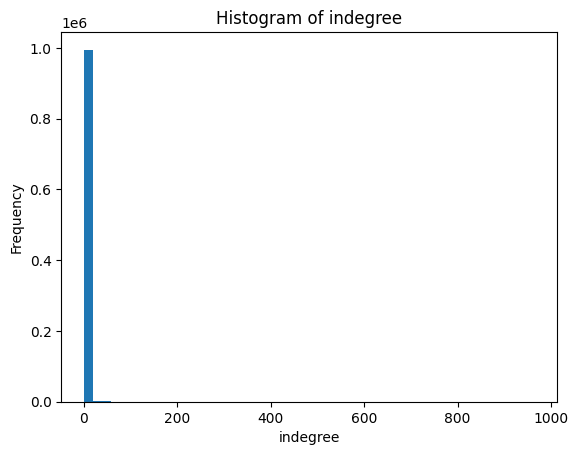

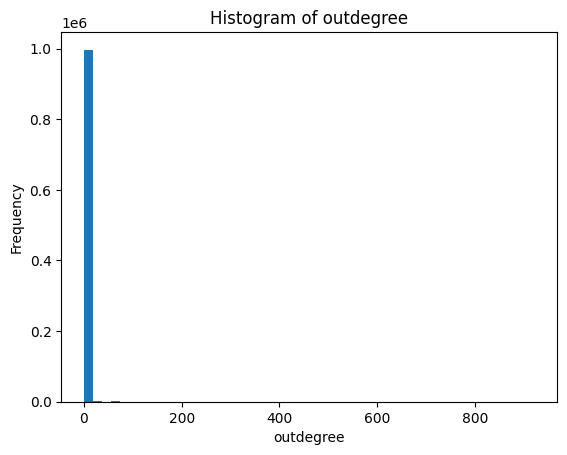

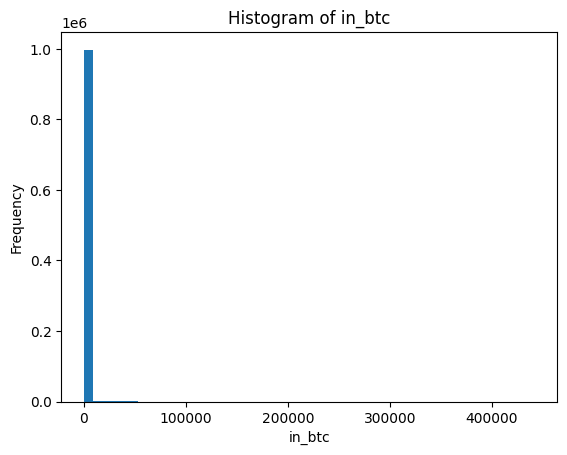

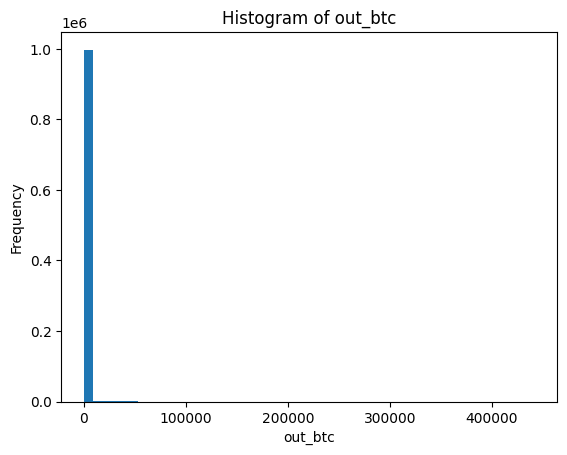

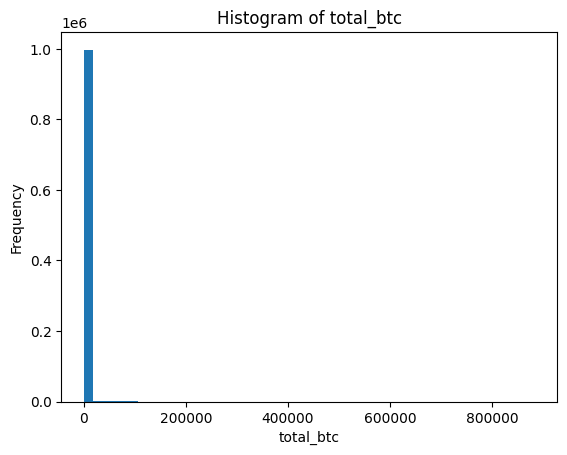

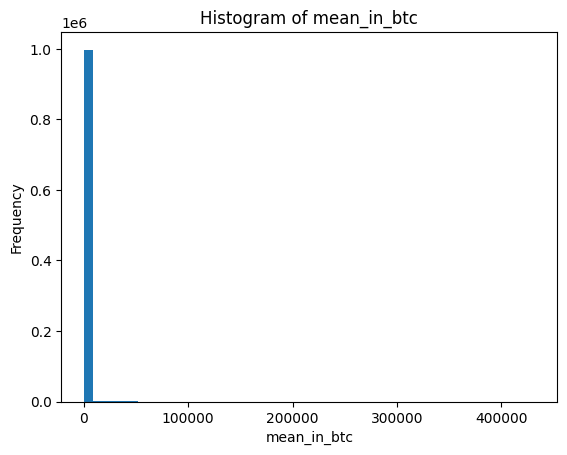

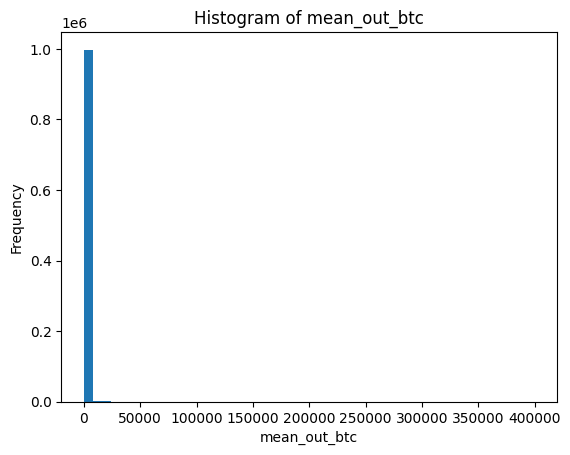

In [92]:
# Multiclass/Continuous variables/attributes/columns Histograms
if show_visualizations and show_histograms:
  for multiclass_column_name in multiclass_columns:
    show_column_histogram(multiclass_column_name)

Based on the histograms of multiclass_columns list, there are more than one value other than 0, but hard to visualize the values more than 0.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

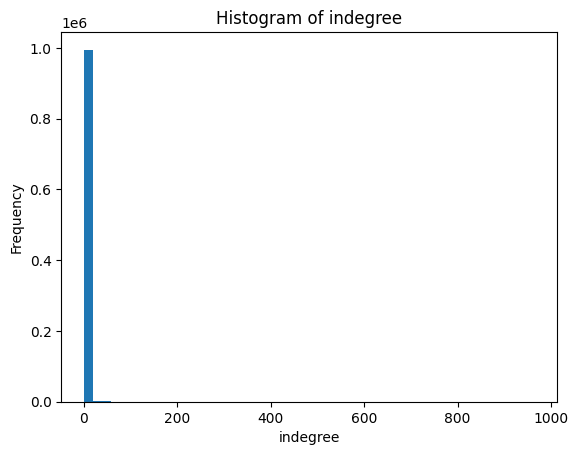

In [93]:
if show_visualizations and show_histograms:
  show_column_histogram('indegree')

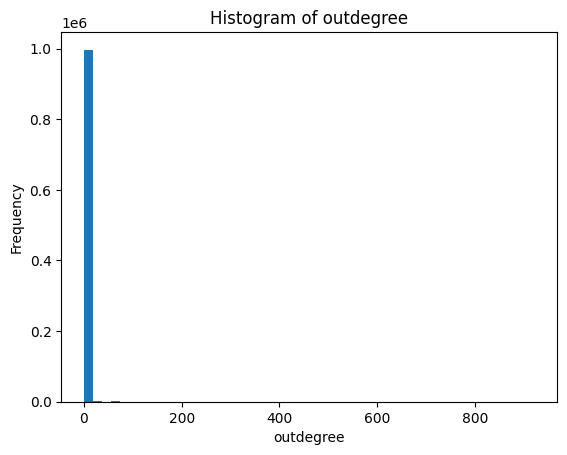

In [94]:
if show_visualizations and show_histograms:
  show_column_histogram('outdegree')

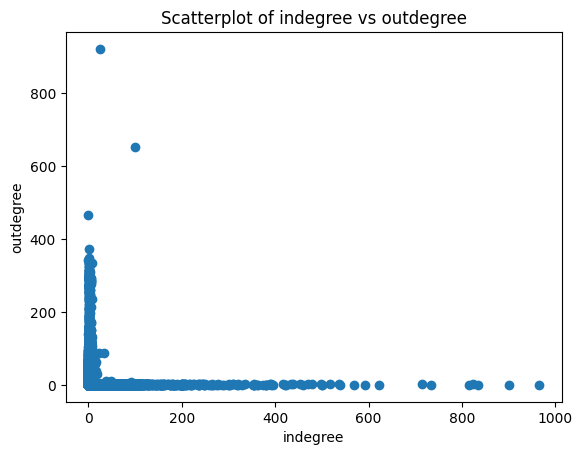

In [95]:
if show_visualizations and show_scatterplots:
  show_column_scatterplot('indegree','outdegree')

From the above Diagram, indegree and outdegree does not follow the normal distribution and linear relationship with each other.

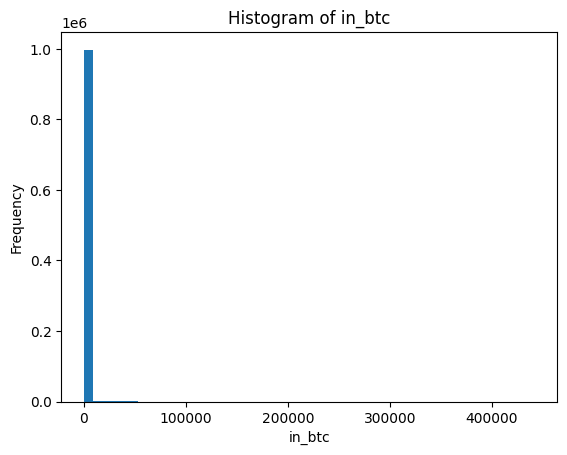

In [96]:
if show_visualizations and show_histograms:
  show_column_histogram('in_btc')
  show_column_histogram('out_btc')
  show_column_histogram('total_btc')
  show_column_histogram('is_malicious')
  show_column_histogram('out_and_tx_malicious')
  show_column_histogram('all_malicious')

in_btc, out_btc and total_btc columns have most of the value in zero, with very fine second line which indicates second or more distinct value. Hence, scatterplots are made

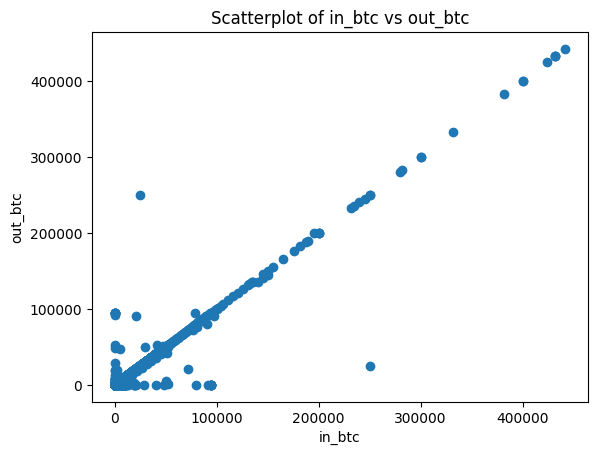

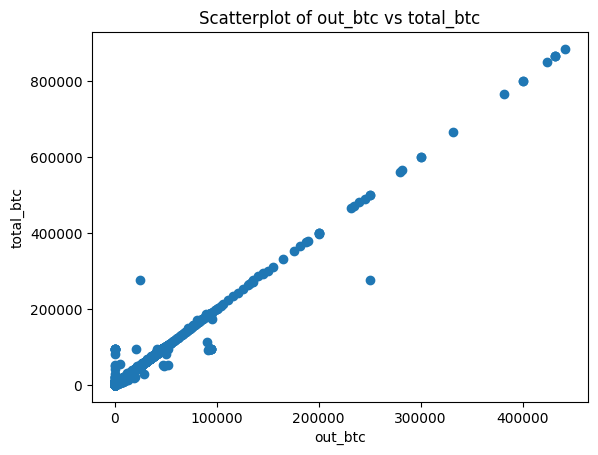

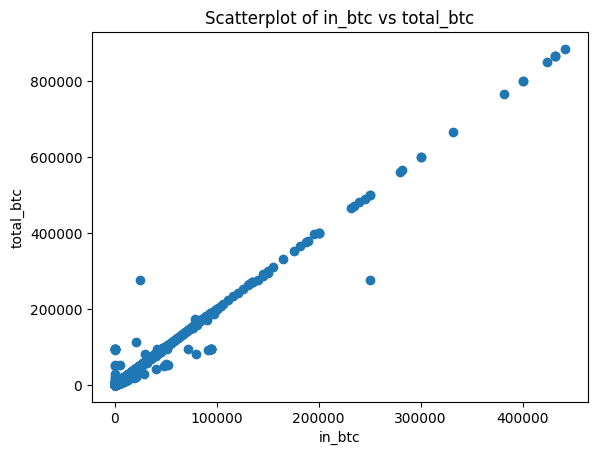

In [99]:
if show_visualizations and show_scatterplots:
  show_column_scatterplot('in_btc','out_btc')
  show_column_scatterplot('out_btc','total_btc')
  show_column_scatterplot('in_btc','total_btc')

From the above visualizations, the data of in_btc, out_btc, total_btc are following normal distributions, with only some outliers needs to be cleaned visually.

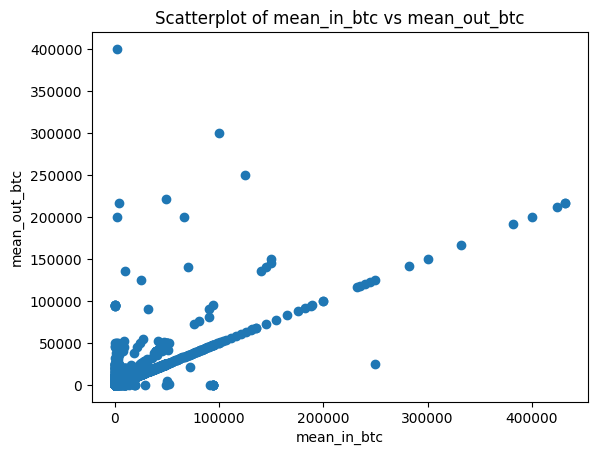

In [103]:
if show_visualizations and show_scatterplots:
  show_column_scatterplot('mean_in_btc','mean_out_btc')
  show_column_scatterplot('in_malicious','out_malicious')
  show_column_scatterplot('out_and_tx_malicious','all_malicious')

Based on the observation of the scatterplot of mean_in_btc vs mean_out_btc above, most of the data is following normal distribution, with minimal data outlier spotted. 

# Detecting Outliers

## Z-Score

### FAQs

* Why 3 is the standard value of *z-score*?

The value 3 is often used as a standard threshold for identifying outliers based on their *Z-scores* because it corresponds to approximately **99.7%** of the data being within the range of 3 standard deviations from the mean in a normal distribution.

In other words, if the distribution of the data is approximately normal, then any values with a *Z-score* greater than 3 or less than -3 are very unlikely to occur by chance, and are therefore considered to be outliers. However, it is worth noting that the choice of the threshold value for identifying outliers can depend on the specific context and the distribution of the data, and there may be cases where a different threshold value is more appropriate.

In [106]:
# Z-Score Methods

z_score_threshold = 3

def calculate_z_score(column_name):
  z_scores = (df[column_name] - df[column_name].mean()) / df[column_name].std()
  print(f'The z-score of the {column_name} is: {z_scores}')
  return z_scores;

def get_outliers_by_z_score(column_name, z_scores):
  outliers = df[abs(z_scores) > z_score_threshold]
  num_outliers = outliers.shape[0]  # get the number of rows in the outliers DataFrame
  print(f'Number of outliers in {column_name}: {num_outliers}')
  print(outliers.head())

def remove_outliers_by_z_score(column_name, z_scores):
  df_filtered = df[abs(z_scores) <= z_score_threshold]
  return df_filtered


## Inter-Quartile Range (IQR)



In [107]:
# Inter-Quartile Range Methods

def remove_outliers_by_iqr(column_name):
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  
  df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
  
  num_outliers = df.shape[0] - df_filtered.shape[0]
  print(f'Number of outliers in {column_name}: {num_outliers}')

  return df_filtered

In [108]:
def remove_outliers_all_columns():
  for index, column_name in enumerate(multiclass_columns):
      # Z-Score
      if remove_outliers_with_z_score:
        z_scores = calculate_z_score(column_name)
        get_outliers_by_z_score(column_name,z_scores)
        df = remove_outliers_by_z_score(column_name, z_scores)

      # IQR
      if remove_outliers_with_IQR:
        df = remove_outliers_by_iqr(column_name)
  return df;

df = remove_outliers_all_columns()

The z-score of the indegree is: 0        -0.300855
1        -0.110560
2        -0.110560
3        -0.110560
4        -0.110560
            ...   
999995   -0.300855
999996   -0.110560
999997    0.460326
999998   -0.110560
999999   -0.110560
Name: indegree, Length: 1000000, dtype: float64
Number of outliers in indegree: 5916
                                               tx_hash  indegree  outdegree  \
29   2ccc3f59d28c709770a8bc478b112e10feda4bf55197c2...        20          1   
98   c1c590ef9400b8dc52335328eaf59844ab98b953ab60c5...        30          1   
108  5559270f3e12c0b9136cb6caf147322669394d2c9b90fd...        20          1   
190  aaaa2ef07c4aa47a15375ba6a920a0e93b82a4307d5d45...       901          1   
196  cec658ace2eb9fe79473a0161ea726a69924fdc17d59c3...        44          1   

       in_btc  out_btc  total_btc  mean_in_btc  mean_out_btc  in_malicious  \
29    1000.00   1000.0    2000.00    50.000000        1000.0             0   
98    1500.00   1500.0    3000.00    50.000

**CHECK** the datasets after outlier removal

In [109]:
df.shape

(930797, 13)

# Building DNN

## Randomize the dataset records

In [110]:
df = df.sample(frac=1)

## Remove uneccessary columns

In [111]:
# Remove tx_hash
df = df.drop('tx_hash', axis=1)

In [112]:
target_variable = 'is_malicious'
Y = df[target_variable]
X = df.drop([target_variable],axis=1)

## Correlation Matrix
Before that, check the correlation of the binary columns to prevent overfitting issue in the model later.

In [113]:
binary_df = df[binary_columns]

# compute the correlation matrix
corr_matrix = binary_df.corr(method='pearson')

# print the correlation matrix
print(corr_matrix)

                      in_malicious  out_malicious  is_malicious  \
in_malicious                   1.0            NaN           NaN   
out_malicious                  NaN            NaN           NaN   
is_malicious                   NaN            NaN           NaN   
out_and_tx_malicious           NaN            NaN           NaN   
all_malicious                  1.0            NaN           NaN   

                      out_and_tx_malicious  all_malicious  
in_malicious                           NaN            1.0  
out_malicious                          NaN            NaN  
is_malicious                           NaN            NaN  
out_and_tx_malicious                   NaN            NaN  
all_malicious                          NaN            1.0  


Based on the output above, there are many NaN values in the correlation matrix,mean that there is no correlation between those pairs of binary columns. In other words, those pairs of binary columns do not share a linear relationship with each other.

Hence, the other binary columns don't have to be removed when one of the target variable is selected from the binary columns.






## Dataset Split
Split the datasets in 20:80 ratio. With fixed random seed to allow reproducible results.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

# Print the datasets' dimension shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(744637, 11) (186160, 11) (744637,) (186160,)


## Data Normalization

The purpose of scaling the data using the StandardScaler function is to transform the data so that each feature has zero mean and unit variance. This is important because some features may have larger magnitudes or ranges of values than others, which can cause bias in the model. By scaling the data, all features are given equal importance, regardless of their original scales. Additionally, scaling can help the model converge more quickly during training.

The fit_transform method is used on the training data to compute the mean and standard deviation of each feature and then transform the data accordingly. The transform method is used on the test data to transform the data using the same mean and standard deviation values computed from the training data.

* X: the dataset features (independent variables)
* Y: the dataset target (dependent variable)
* test_size: the percentage of data that should be used for testing (in this case, 20%)
* random_state: a random seed for reproducibility of the split

In [115]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Initial model:

In [116]:
# Number of neurals. No harm in changing the numbers, no guidelines here.
L1 = 64 # First hidden layer neurons
L2 = 32 # Second hidden layer neurons


# Activation functions
activation_function = 'relu'
activation_function2 = 'relu'
output_activation_function = 'sigmoid' # Multi-class = softmax, Binary = sigmoid, continuous = linear

# Number of outputs
# You need to know your columns, for example, you only made a column "Price", so here only one value.
no_of_output = 1

# Initialize object
model = Sequential()

# First hidden layer
model.add(Dense(L1, input_dim=X_train.shape[1], activation=activation_function))

# Dropout Layer
model.add(Dropout(0.3))

# Second hidden layer
model.add(Dense(L2, activation=activation_function2))

# Dropout Layer
model.add(Dropout(0.3))

# Output layer
model.add(Dense(no_of_output,activation=output_activation_function,kernel_regularizer=regularizers.l2(0.01)))

In [117]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [118]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
4654/4654 [==============================] - 19s 4ms/step - loss: 0.0094 - accuracy: 0.9998 - val_loss: 3.6934e-04 - val_accuracy: 1.0000
Epoch 2/50
4654/4654 [==============================] - 14s 3ms/step - loss: 2.4829e-04 - accuracy: 1.0000 - val_loss: 7.4789e-05 - val_accuracy: 1.0000
Epoch 3/50
4654/4654 [==============================] - 20s 4ms/step - loss: 6.0273e-05 - accuracy: 1.0000 - val_loss: 2.3141e-05 - val_accuracy: 1.0000
Epoch 4/50
4654/4654 [==============================] - 18s 4ms/step - loss: 1.8477e-05 - accuracy: 1.0000 - val_loss: 7.6682e-06 - val_accuracy: 1.0000
Epoch 5/50
4654/4654 [==============================] - 15s 3ms/step - loss: 7.8517e-06 - accuracy: 1.0000 - val_loss: 3.8673e-06 - val_accuracy: 1.0000
Epoch 6/50
4654/4654 [==============================] - 17s 4ms/step - loss: 3.9571e-06 - accuracy: 1.0000 - val_loss: 1.6337e-06 - val_accuracy: 1.0000
Epoch 7/50
4654/4654 [==============================] - 17s 4ms/step - loss: 2.3553e-0

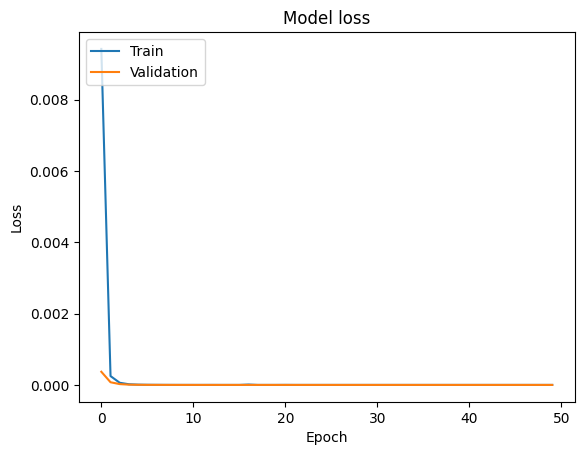

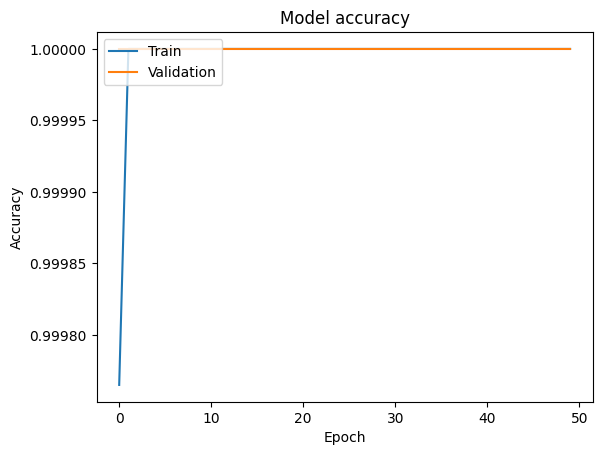

In [119]:
# Plot the loss and accuracy over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()